In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sqlmodel import create_engine, SQLModel, Session
from dotenv import load_dotenv

load_dotenv()

db_host = os.environ.get("DB_HOST")
db_user = os.environ.get("DB_USER")
db_password = os.environ.get("DB_PASSWORD")
db_database = os.environ.get("DB_DATABASE")
db_port = os.environ.get("DB_PORT")


postgres_uri = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_database}"

engine = create_engine(postgres_uri, echo=False)

videosTable = "youtube_videos"
videoStatsTable = "youtube_video_stats"
channelsTable = "youtube_channels"
statsTable = "youtube_stats"

# Compared channels

In [55]:
targetChannelId = "4aafe41c-1caa-4628-8b1b-896b781fd11a"
channels = ["31ad21f4-7b35-4a76-af1f-3f5be21b385f"]
channels.append(targetChannelId)
channel_ids = ','.join([f"'{channel}'" for channel in channels])

In [54]:
videoStatsQuery = f'''
SELECT
    {videoStatsTable}.video,
    MAX({videoStatsTable}.views) as views,
    MAX({videoStatsTable}.likes) as likes,
    MAX({videoStatsTable}.comments) as comments
FROM {videoStatsTable}
WHERE {videoStatsTable}.timestamp = (
    SELECT MAX(timestamp) FROM {videoStatsTable} AS latest
    WHERE latest.video = {videoStatsTable}.video
)
GROUP BY {videoStatsTable}.video
'''


channelStatsQuery = f'''
SELECT
    {statsTable}.youtube_channel,
    MAX({statsTable}.subs) as subs,
    MAX({statsTable}.videos) as about_videos
FROM {statsTable}
WHERE {statsTable}.timestamp = (
    SELECT MAX(timestamp) FROM {statsTable} AS latest
    WHERE latest.youtube_channel = {statsTable}.youtube_channel
)
GROUP BY {statsTable}.youtube_channel
'''




query = f'''
SELECT 
    {channelsTable}.username,
    COUNT({videosTable}.uuid) as videos,
    MAX({videosTable}.youtube_channel) as uuid,
    AVG(channel_stats.about_videos) as about_videos,
    AVG(channel_stats.subs) as subs,
    SUM(latest_video_stats.views) as views,
    SUM(latest_video_stats.likes) as likes,
    SUM(latest_video_stats.comments) as comments,
    AVG(latest_video_stats.views) as avg_views,
    AVG(latest_video_stats.likes) as avg_likes,
    AVG(latest_video_stats.comments) as avg_comments,
    MIN(latest_video_stats.views) as min_views,
    MIN(latest_video_stats.likes) as min_likes,
    MIN(latest_video_stats.comments) as min_comments,
    (SUM(latest_video_stats.views)/AVG(channel_stats.subs)) as views_per_sub,
    (SUM(latest_video_stats.likes) / SUM(latest_video_stats.views)) as likes_per_views,
    (SUM(latest_video_stats.comments) / SUM(latest_video_stats.views)) as comments_per_views,
    (AVG(channel_stats.subs) / COUNT({videosTable}.uuid)) as subs_per_video
FROM {videosTable}
    LEFT JOIN {channelsTable} ON {channelsTable}.uuid = {videosTable}.youtube_channel
    LEFT JOIN (
        {videoStatsQuery}
    ) latest_video_stats ON latest_video_stats.video = {videosTable}.uuid
    LEFT JOIN (
        {channelStatsQuery}
    ) channel_stats ON channel_stats.youtube_channel = {videosTable}.youtube_channel
WHERE
    {videosTable}.youtube_channel IN ({channel_ids})
GROUP BY {channelsTable}.username
'''


df = pd.read_sql(query, engine, index_col="uuid")
df['is_target'] = df.index == targetChannelId
df.round(1).T

uuid,4aafe41c-1caa-4628-8b1b-896b781fd11a,31ad21f4-7b35-4a76-af1f-3f5be21b385f
username,ChemaEspejo,xaviesqueriguela
videos,866,73
about_videos,919.0,260.0
subs,21100.0,11000.0
views,2476204.0,1551258.0
likes,41444.0,7985.0
comments,4047.0,1728.0
avg_views,2859.4,21250.1
avg_likes,47.9,109.4
avg_comments,4.7,23.7


In [56]:
query = f'''
SELECT
    {videosTable}.title,
    MAX({videosTable}.youtube_channel) as youtube_channel,
    MAX({channelsTable}.username) as channel,
    MAX({videoStatsTable}.views) as views,
    MAX({videoStatsTable}.likes) as likes,
    MAX({videoStatsTable}.comments) as comments,
    MAX({videoStatsTable}.date) as date,
    CASE
        WHEN MAX({statsTable}.subs) > 0 THEN MAX({videoStatsTable}.views) / MAX({statsTable}.subs)
        ELSE 0.0 -- Handle division by zero by returning 0.0 (you can use NULL or another value as well)
    END as views_per_subs,
    CASE
        WHEN MAX({videoStatsTable}.views) > 0 THEN MAX({videoStatsTable}.likes) / MAX({videoStatsTable}.views)
        ELSE 0.0 -- Handle division by zero by returning 0.0 (you can use NULL or another value as well)
    END as likes_per_views,
    CASE
        WHEN MAX({videoStatsTable}.views) > 0 THEN MAX({videoStatsTable}.comments) / MAX({videoStatsTable}.views)
        ELSE 0.0 -- Handle division by zero by returning 0.0 (you can use NULL or another value as well)
    END as comments_per_views,
    MAX({statsTable}.subs) as subs
FROM {videosTable}
    LEFT JOIN {videoStatsTable} ON {videoStatsTable}.video = {videosTable}.uuid
    LEFT JOIN {statsTable} ON {statsTable}.youtube_channel = {videosTable}.youtube_channel
    LEFT JOIN {channelsTable} ON {channelsTable}.uuid = {videosTable}.youtube_channel
WHERE {videosTable}.youtube_channel IN ({channel_ids})
GROUP BY {videosTable}.title
'''
df = pd.read_sql(query, engine, index_col='title')

totalVideos = len(df.index)
nullDates = np.sum(pd.isnull(df['date']))
print(f"Null dates: {nullDates}/{totalVideos} ({round(nullDates/totalVideos*100, 2)}%)")

nullViews = np.sum(pd.isnull(df['views']))
print(f"Null views: {nullViews}/{totalVideos} ({round(nullViews/totalVideos*100, 2)}%)")

nullSubs = np.sum(pd.isnull(df['subs']))
print(f"Null subs: {nullSubs}/{totalVideos} ({round(nullSubs/totalVideos*100, 2)}%)")

df['is_target'] = df["youtube_channel"] == targetChannelId

df.sort_values(by=["views"], ascending=False)
df['interact'] = df['comments']*100/df['views']

Null dates: 103/938 (10.98%)
Null views: 0/938 (0.0%)
Null subs: 0/938 (0.0%)


## Best Videos

In [34]:
mostViewed = df['views'].idxmax()
mostCommented = df['comments'].idxmax()
mostLiked = df['likes'].idxmax()
mostInteract = df['interact'].idxmax()
tags = ['Most viewed', 'Most commented', 'Most liked', 'Most interacted']
indexes = [mostViewed, mostCommented, mostLiked, mostInteract]

# Filtrar el DataFrame original para obtener las filas correspondientes a los índices destacados
bestVideosDF = df.loc[indexes]
bestVideosDF['Tag'] = tags

column_order = ['Tag'] + [col for col in bestVideosDF.columns if col != 'Tag']
bestVideosDF = bestVideosDF[column_order]

bestVideosDF

,Tag,youtube_channel,channel,views,likes,comments,date,views_per_subs,likes_per_views,comments_per_views,subs,is_target,interact
title,,,,,,,,,,,,,
Instagram direct pc: Como mandar mensajes directos en instagram desde el ordenador,Most viewed,4aafe41c-1caa-4628-8b1b-896b781fd11a,ChemaEspejo,306718.0,1589.0,195.0,2018-06-27,14.536398,0.005181,0.000636,21100.0,True,0.063576
Me voy a VIVIR a ANDORRA 🇦🇩 | Cuento los DETALLES,Most commented,31ad21f4-7b35-4a76-af1f-3f5be21b385f,xaviesqueriguela,94150.0,1499.0,585.0,2022-11-09,8.559091,0.015921,0.006213,11000.0,False,0.621349
🔴Cómo hacer un [FUNNEL DE VENTAS GRATIS]🚀 (te lo juro),Most liked,4aafe41c-1caa-4628-8b1b-896b781fd11a,ChemaEspejo,79509.0,4178.0,146.0,2020-04-15,3.768199,0.052548,0.001836,21100.0,True,0.183627
Respondo las preguntas de suscriptores - Chema Espejo,Most interacted,4aafe41c-1caa-4628-8b1b-896b781fd11a,ChemaEspejo,58.0,5.0,9.0,2020-12-02,0.002749,0.086207,0.155172,21100.0,True,15.517241


Text(0, 0.5, 'Comments')

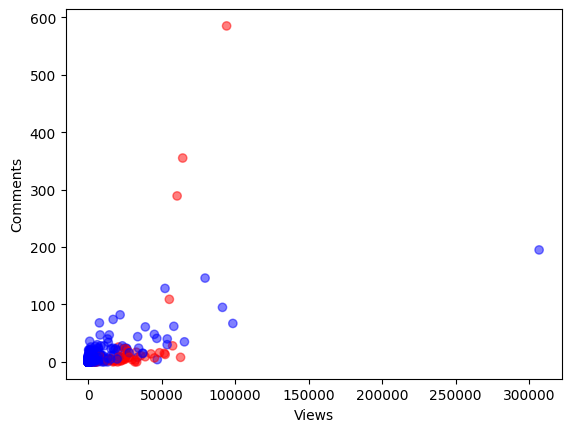

In [35]:
colors = ['blue' if is_target else 'red' for is_target in df['is_target']]

plt.scatter(df['views'], df['comments'], alpha=0.5, c=colors)  
plt.xlabel('Views')
plt.ylabel('Comments')

Text(0, 0.5, 'Views')

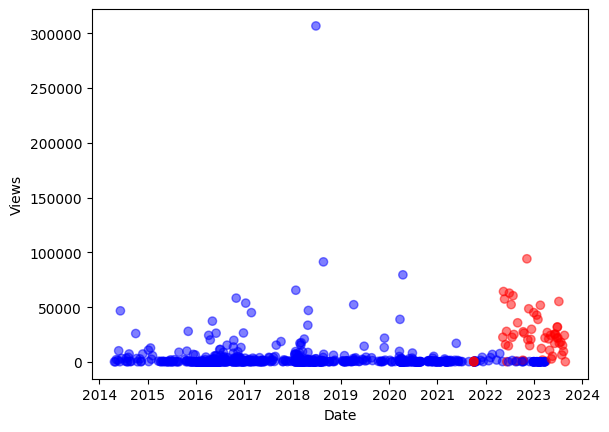

In [36]:
colors = ['blue' if is_target else 'red' for is_target in df['is_target']]

plt.scatter(df['date'], df['views'], alpha=0.5, c=colors)  
plt.xlabel('Date')
plt.ylabel('Views')